<span style="font-weight:bold; font-size:35px; line-height:1.0;">EDA: Predicting Home Sale Prices in King County </span>

<figure style="margin-top:10px"><img src="https://www.racialequityalliance.org/wp-content/uploads/2016/10/assessors_social-1.jpg" />
<figcaption style="font-size:8px">source: https://www.racialequityalliance.org/jurisdictions/king-county-washington/assessors_social/</figcaption>
</figure>




# Initial Imports and Data Cleaning

## Import Libraries and Custom Functions

The following code will import our custom functions from Mod1_Functions.py.

We also import pandas, numpy, matplotlib, seaborn, statsmodels, and scikit-learn.

In [1]:
from Mod1_Functions import *


## Import Raw Dataset

We import the csv data into a pandas dataframe by using `pandas.read_csv()`.

In [2]:
df_raw = pd.read_csv('kc_house_data.csv')

We can take a quick look at the data field types using `df_raw.info()`

In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


From `.info()` we can see that `waterfront`, `view`, and `yr_renovated` are missing values.

`date` is formatted as an object type, instead of a date (datetime64).

`sqft_basement` is also formatted as an object type, when we would expect 

Let's take a look at some scatter plots of each potential X variable compared to our target `'price'`.

The custom function below accepts inputs of a dataframe and the name of the column that is the target.  Additional parameters can also be passed through to adjust the formatting.

Warnings are printed for any variables that cannot immediately be graphed as numbers.

In [4]:
#scatter_y(df_raw, 'price')

In [5]:
#df_raw.iloc[:, 2:].hist(figsize  = [16, 10])
#plt.subplots_adjust(wspace=0.5, hspace=0.6)

## Clean data using custom function

Our `clean_dataframe()` function takes in inputs of dataframe and a dictionary of adjustments.

We first set our `data_adjustments` dictionary to contain the fields we want to change as keys and a list of adjustments as dictionary values.

The parameters in the list are: \[datatype, value to replace, value to replace with, replacement array\]

    - datatype: must be a valid data type
    - value to replace: can be a single value string, integer, or np.nan
    - value to replace with: can be a single value or can be a list with strings containg other column names in dataframe (see replacement array below)
    - replacement array: contains a list of floats or integers, which are multiplied by the associated data field in the "value to replace with" list
    
The list items should be set to None for any parameters you do not wish to use.

In [6]:
data_adjustments = {'date': ['datetime64', None, None, None],
                    'bedrooms': [None, 33, 4, None],
                    'waterfront': [str, np.nan, 'missing', None],
                    'view': [str, np.nan, 0, None],
                    'sqft_basement': [float, '?', ['sqft_living', 'sqft_above'], [1, -1]]
                    }

In [7]:
df_clean = clean_dataframe(df_raw, data_adjustments)

## Add features calculated from other columns

We create a few fields calculated based on the date of sale (day of week, day, and month).

We also create a custom binned variable `'yr_renovated_cat'` which categorizes whether the house has been renovated and whether that renovation was recent.

In [8]:
df_clean['month'] = df_clean['date'].map(lambda x: x.month)

df_clean['season'] = df_clean['month'].apply(create_season)

df_clean['has_basement'] = df_clean['sqft_basement'].apply(lambda x: 1 if x>0 else 0)

# Set number of years to consider recent renovation
n_years = 15
df_clean['yr_renovated_cat'] = df_clean['yr_renovated'].apply(
    renovated_cat, n_years=n_years)

## Set up data fields as Categorical to avoid treating as numbers

In [9]:
categorical_columns = ['floors', 'waterfront', 'view', 'condition',
                       'grade', 'zipcode', 'yr_renovated_cat', 'season']

set_to_categorical(df_clean, categorical_columns)

print(df_clean.dtypes)

id                           int64
date                datetime64[ns]
price                      float64
bedrooms                     int64
bathrooms                  float64
sqft_living                  int64
sqft_lot                     int64
floors                    category
waterfront                category
view                      category
condition                 category
grade                     category
sqft_above                   int64
sqft_basement              float64
yr_built                     int64
yr_renovated               float64
zipcode                   category
lat                        float64
long                       float64
sqft_living15                int64
sqft_lot15                   int64
month                        int64
season                    category
has_basement                 int64
yr_renovated_cat          category
dtype: object


In [10]:
df_dummy = create_dummyframe(df_clean, categorical_columns)

print('df_dummy shape: {}'.format(df_dummy.shape))
print('\nPreview:')
df_dummy.head()


df_dummy shape: (21597, 108)

Preview:


,floors_1.0,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,waterfront_0.0,waterfront_1.0,waterfront_missing,view_0.0,...,zipcode_98198,zipcode_98199,yr_renovated_cat_Never Renovated,yr_renovated_cat_Prior to 2000,yr_renovated_cat_Since 2000 inclusive,yr_renovated_cat_missing,season_Fall,season_Spring,season_Summer,season_Winter
0,1,0,0,0,0,0,0,0,1,1,...,0,0,1,0,0,0,1,0,0,0
1,0,0,1,0,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,1
2,1,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,1
3,1,0,0,0,0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,1
4,1,0,0,0,0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,1


Let's consider a log-linear relationship by adding a `'log_price'` column.

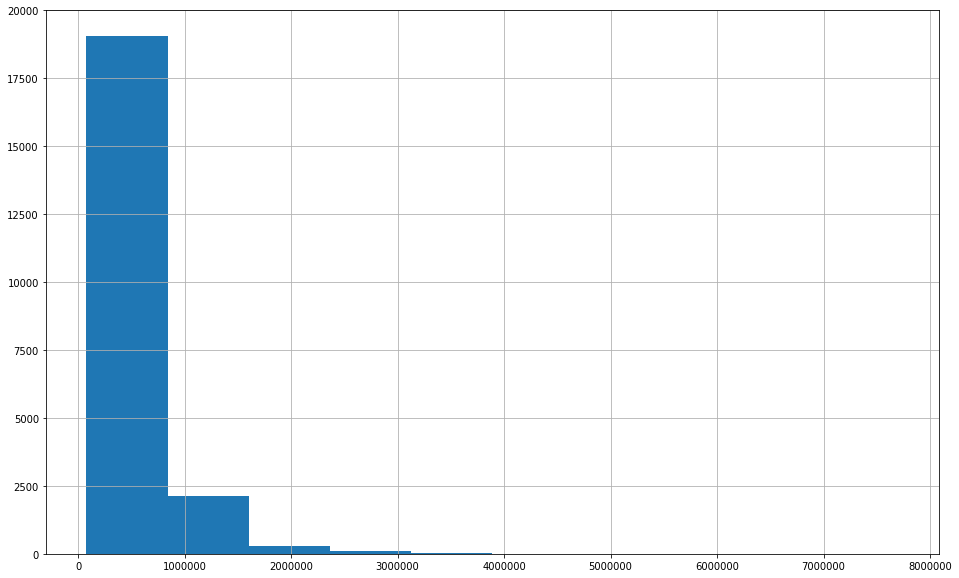

In [11]:
df_clean.price.hist(figsize  = [16, 10])

In [12]:
df_clean['log_price'] = np.log(df_clean['price'])

And take another look at the scatter plots compared to the new target of `'log_price'` 

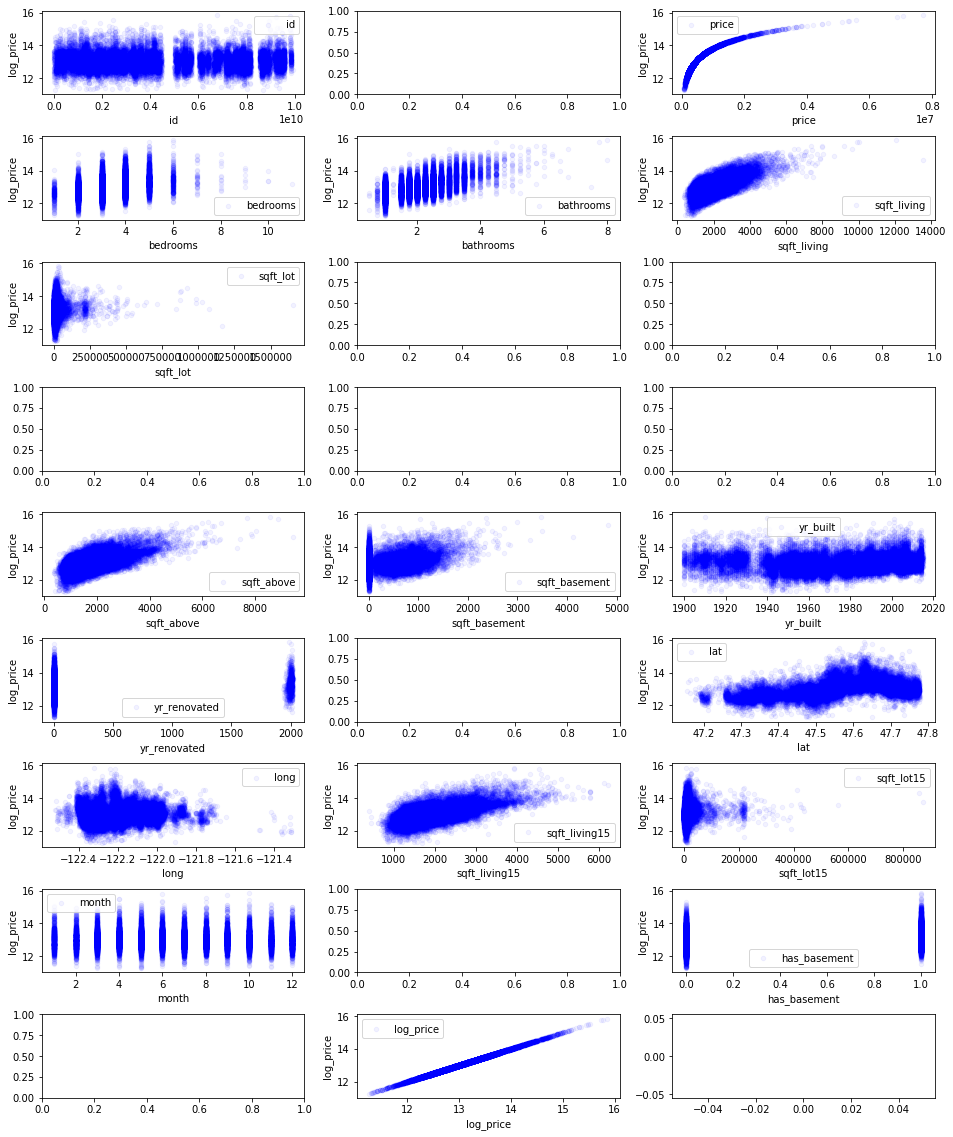

In [13]:
scatter_y(df_clean, 'log_price')

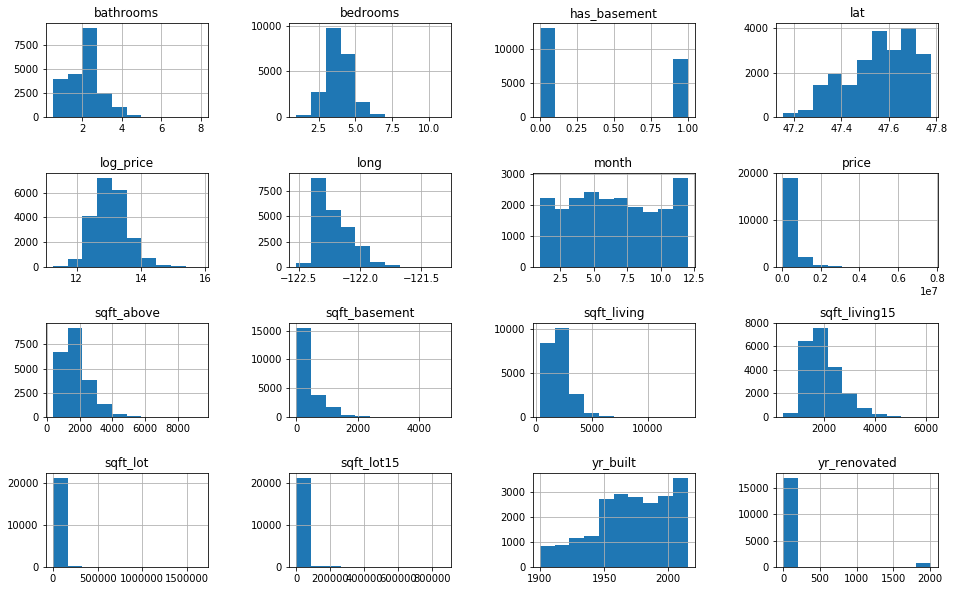

In [14]:
df_clean.iloc[:, 2:].hist(figsize  = [16, 10])
plt.subplots_adjust(wspace=0.5, hspace=0.6)

waterfront
0.0        5.326420e+05
1.0        1.717215e+06
missing    5.294301e+05
Name: price, dtype: float64

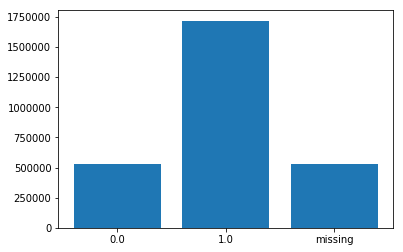

In [15]:
waterfront_grouped = df_clean.groupby('waterfront')['price'].mean()
plt.bar(x=waterfront_grouped.index, height=waterfront_grouped)
waterfront_grouped

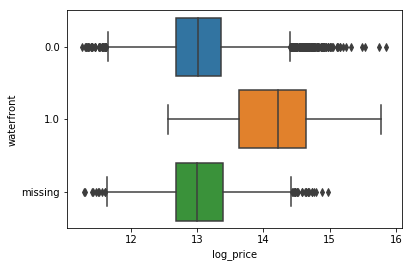

In [16]:
sns.boxplot(x='log_price', y='waterfront', data=df_clean);

yr_renovated_cat
Never Renovated         530677.535536
Prior to 2000           703728.909589
Since 2000 inclusive    831667.430079
missing                 538617.004945
Name: price, dtype: float64

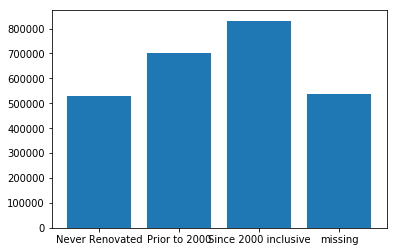

In [17]:
yr_renovated_grouped = df_clean.groupby('yr_renovated_cat')['price'].mean()
plt.bar(x=yr_renovated_grouped.index, height=yr_renovated_grouped)
yr_renovated_grouped

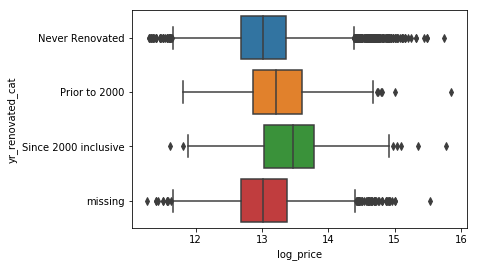

In [18]:
sns.boxplot(x='log_price', y='yr_renovated_cat', data=df_clean);

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


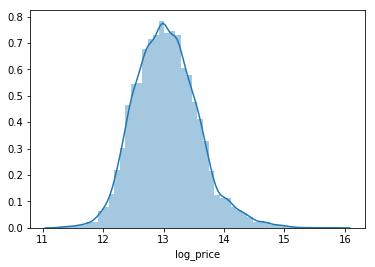

In [19]:
sns.distplot(df_clean.log_price)

In [20]:
corr = df_clean.corr()

cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

corr.style.background_gradient(cmap, axis=1).set_precision(2)
    

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,month,has_basement,log_price
id,1,-0.017,0.0023,0.0052,-0.012,-0.13,-0.011,-0.0052,0.022,-0.012,-0.0018,0.021,-0.0027,-0.14,-0.012,0.0026,-0.0038
price,-0.017,1,0.32,0.53,0.7,0.09,0.61,0.32,0.054,0.13,0.31,0.022,0.59,0.083,-0.0099,0.18,0.89
bedrooms,0.0023,0.32,1,0.53,0.59,0.034,0.49,0.31,0.16,0.019,-0.012,0.14,0.4,0.032,-0.0008,0.16,0.35
bathrooms,0.0052,0.53,0.53,1,0.76,0.088,0.69,0.28,0.51,0.051,0.024,0.22,0.57,0.088,0.0075,0.16,0.55
sqft_living,-0.012,0.7,0.59,0.76,1,0.17,0.88,0.44,0.32,0.056,0.052,0.24,0.76,0.18,0.012,0.2,0.7
sqft_lot,-0.13,0.09,0.034,0.088,0.17,1,0.18,0.015,0.053,0.0045,-0.086,0.23,0.14,0.72,-0.0026,-0.035,0.1
sqft_above,-0.011,0.61,0.49,0.69,0.88,0.18,1,-0.052,0.42,0.022,-0.0012,0.34,0.73,0.2,0.01,-0.21,0.6
sqft_basement,-0.0052,0.32,0.31,0.28,0.44,0.015,-0.052,1,-0.13,0.074,0.11,-0.14,0.2,0.018,0.0061,0.82,0.32
yr_built,0.022,0.054,0.16,0.51,0.32,0.053,0.42,-0.13,1,-0.23,-0.15,0.41,0.33,0.071,-0.0062,-0.17,0.081
yr_renovated,-0.012,0.13,0.019,0.051,0.056,0.0045,0.022,0.074,-0.23,1,0.032,-0.072,-0.00025,0.0039,0.0088,0.052,0.12


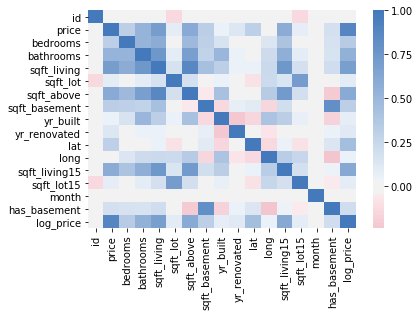

In [21]:
sns.heatmap(df_clean.corr(), center=0, cmap=cmap);

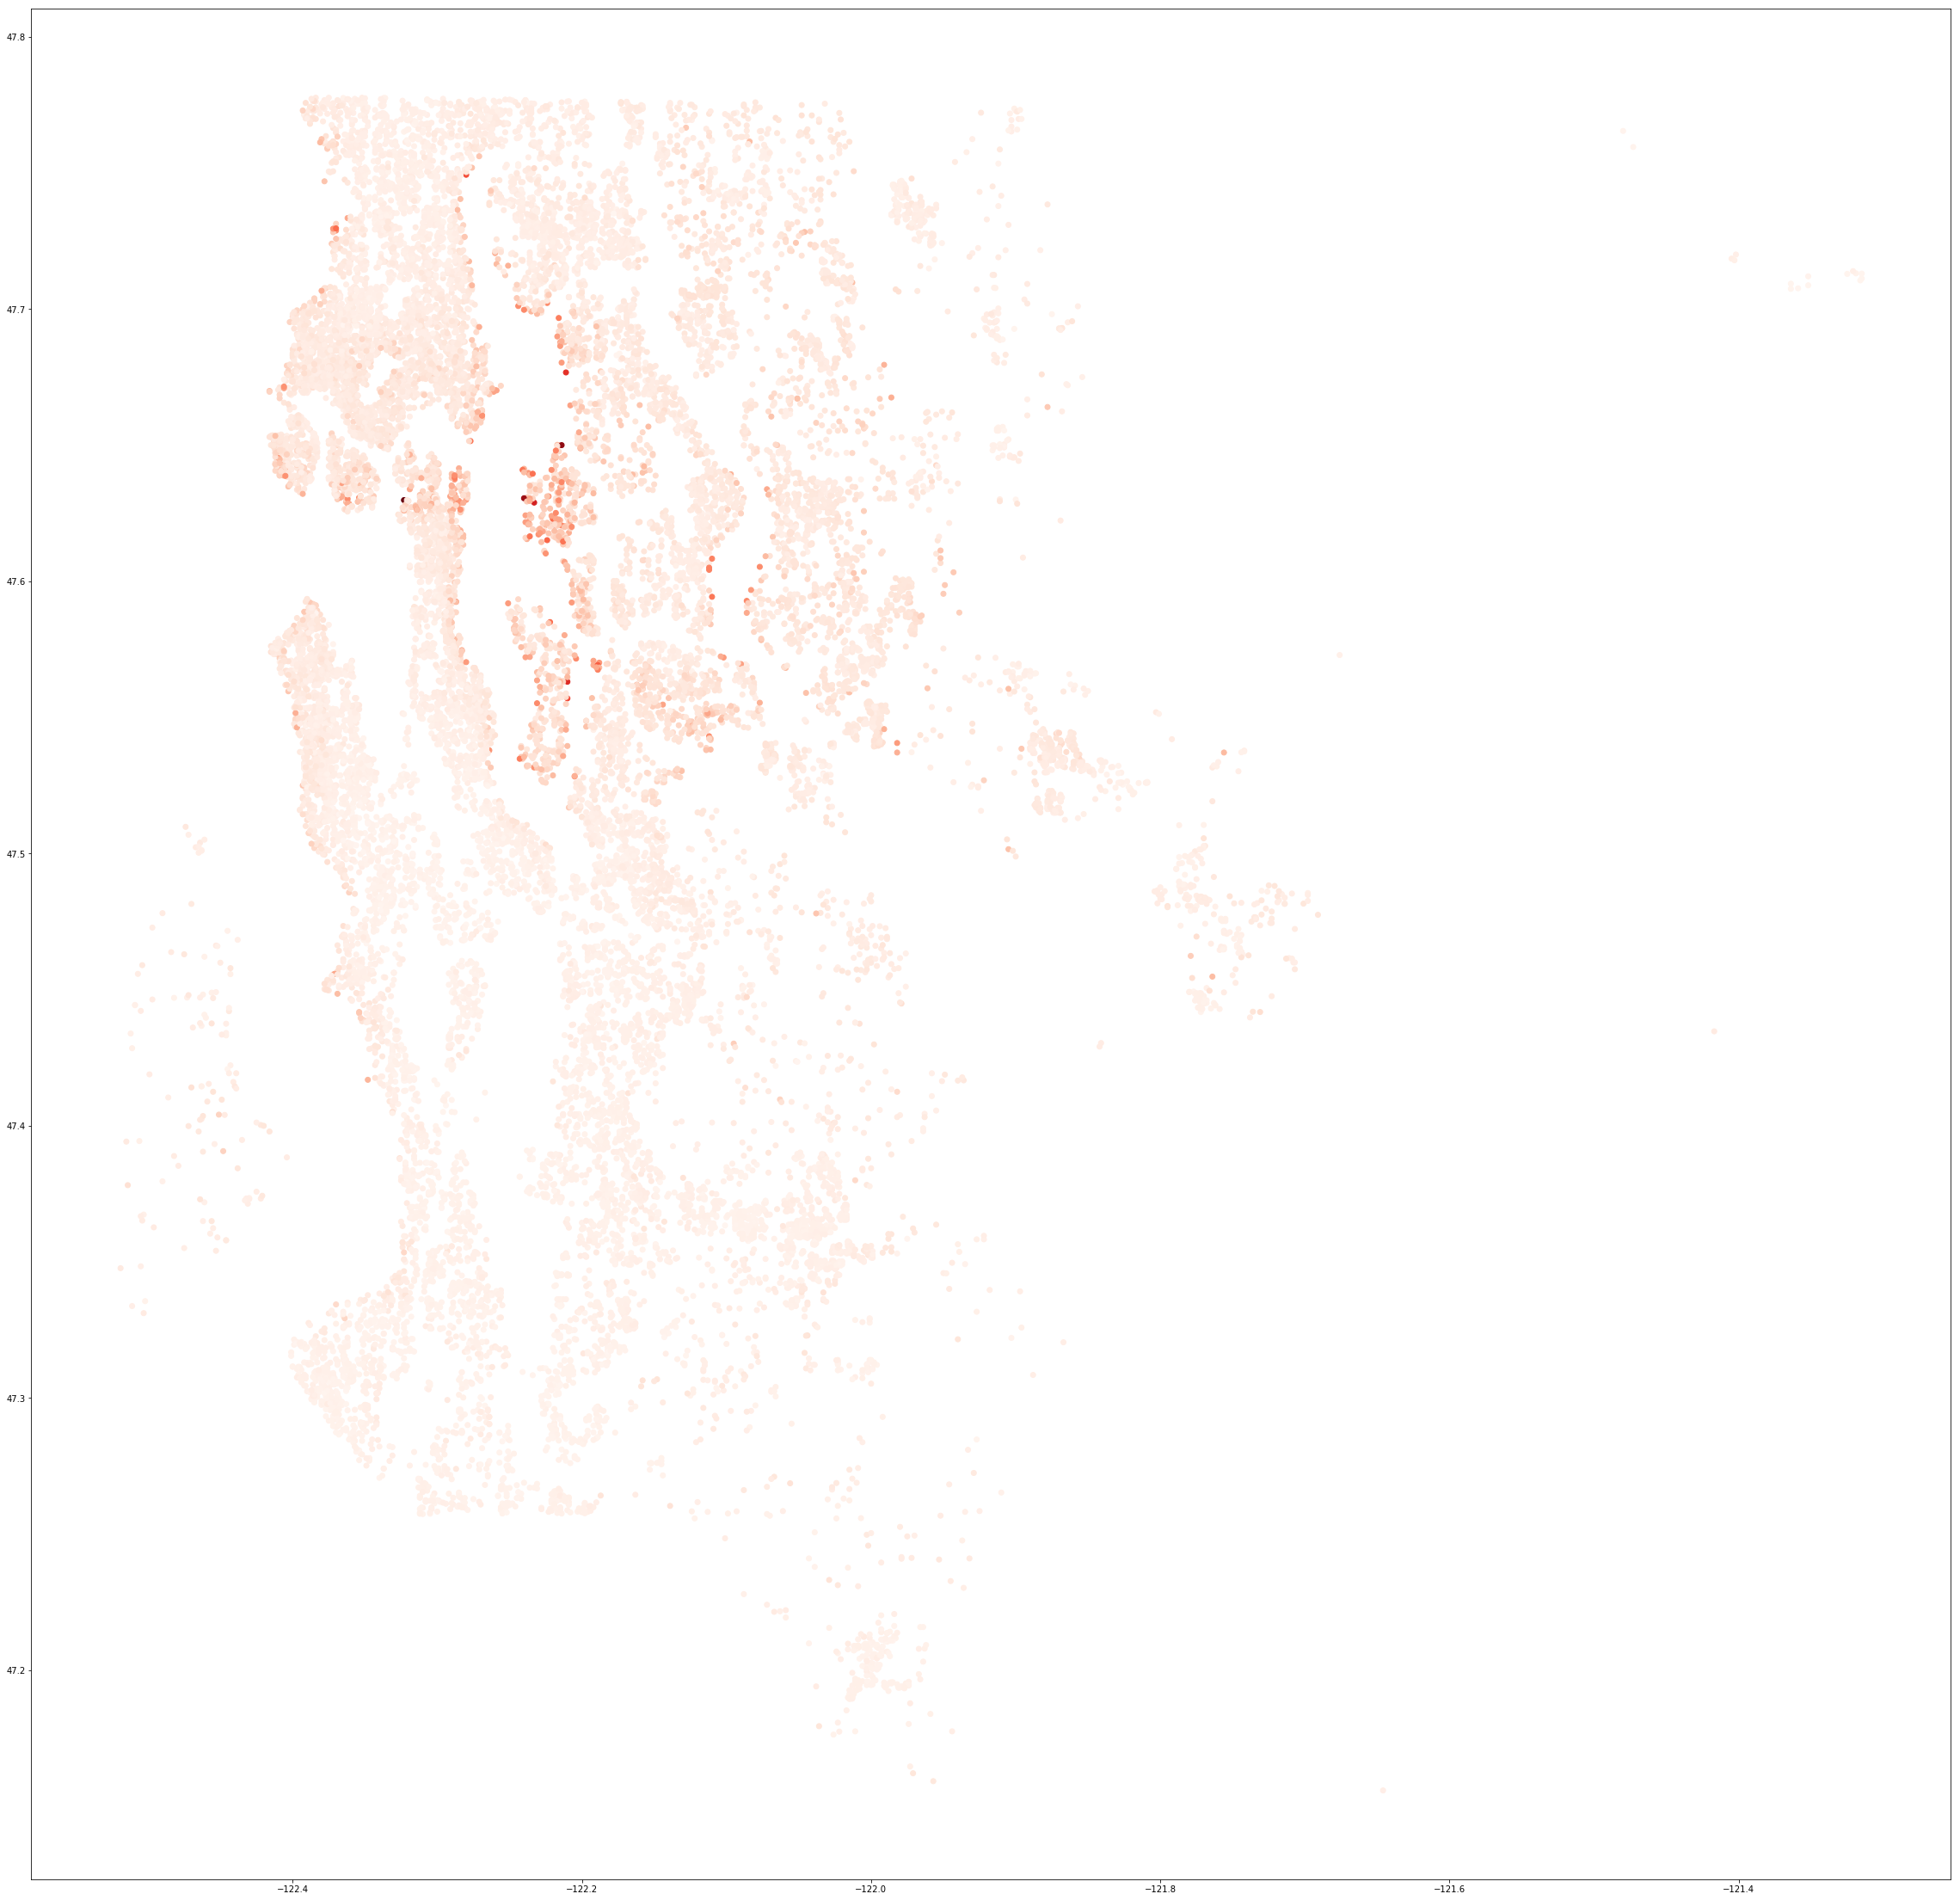

In [22]:
plt.figure(figsize=(40,40))
plt.scatter(df_clean.long, df_clean.lat, alpha=1, c=df_clean.price, cmap='Reds')

In [23]:
x_list = ["bedrooms", 
          "bathrooms", 
          "sqft_above", 
          "sqft_basement", 
          "sqft_lot", 
          "sqft_living15", 
          "sqft_lot15"]

In [24]:
#formula = 'log_price ~ bedrooms+bathrooms+sqft_above+sqft_basement+sqft_lot+sqft_living15+sqft_lot15'
#model = ols(formula, data=df_clean).fit()
#model.summary()

X = df_clean.loc[:, x_list]
X = sm.add_constant(X)
Y = df_clean['log_price']


model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     3287.
Date:                Tue, 07 May 2019   Prob (F-statistic):               0.00
Time:                        12:24:37   Log-Likelihood:                -8957.3
No. Observations:               21597   AIC:                         1.793e+04
Df Residuals:                   21589   BIC:                         1.799e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.1661      0.011   1075.859      0.000      12.144      12.188
bedrooms         -0.0577      0.003    -16.495      0.000      -0.065      -0.051
bathrooms         0.0554      0.005     10.984      0.000       0.045       0.065
sqft_above        0.0003   6.01e-06     47.453      0.000       0.000       0.000
sqft_basement     0.0004   6.99e-06     51.433      0.000       0.000       0.000
sqft_lot       2.409e-07   8.68e-08      2.774      0.006    7.07e-08    4.11e-07
sqft_living15     0.0002   5.73e-06     31.259      0.000       0.000       0.000
sqft_lot15    -1.175e-06   1.33e-07     -8.865      0.000   -1.43e-06   -9.15e-07
==============================================================================
Omnibus:                       25.367   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.469
Skew:                           0.031   Prob(JB):                     1.32e-05
Kurtosis:                       2.855   Cond. No.                     2.36e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.36e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
linreg = LinearRegression()
linreg.fit(X, Y)

print(linreg.coef_)
print(linreg.intercept_)

linreg_coefs = linreg.coef_
linreg_coefs[0] = linreg.intercept_

[ 0.00000000e+00 -5.76832906e-02  5.53819884e-02  2.85269319e-04
  3.59334676e-04  2.40873755e-07  1.79050478e-04 -1.17483758e-06]
12.166119923966159


Compare our two models to see that they produce similar results.

In [26]:
model.params - linreg_coefs

const           -3.179679e-13
bedrooms         1.933176e-14
bathrooms       -3.561734e-14
sqft_above       6.407635e-17
sqft_basement   -3.675445e-17
sqft_lot         4.406525e-17
sqft_living15    2.087089e-17
sqft_lot15       9.186708e-18
dtype: float64

In [27]:
df_clean.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'month', 'season',
       'has_basement', 'yr_renovated_cat', 'log_price'],
      dtype='object')

In [28]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 26 columns):
id                  21597 non-null int64
date                21597 non-null datetime64[ns]
price               21597 non-null float64
bedrooms            21597 non-null int64
bathrooms           21597 non-null float64
sqft_living         21597 non-null int64
sqft_lot            21597 non-null int64
floors              21597 non-null category
waterfront          21597 non-null category
view                21597 non-null category
condition           21597 non-null category
grade               21597 non-null category
sqft_above          21597 non-null int64
sqft_basement       21597 non-null float64
yr_built            21597 non-null int64
yr_renovated        17755 non-null float64
zipcode             21597 non-null category
lat                 21597 non-null float64
long                21597 non-null float64
sqft_living15       21597 non-null int64
sqft_lot15          21597 non-nu

In [29]:
log_list = ['sqft_above', 'sqft_basement',
            'sqft_living15', 'sqft_lot', 'sqft_lot15']

# avoid value of 0 in sqft_basement
df_clean['sqft_basement'] = df_clean['sqft_basement'] + 1

for i in log_list:
    try:
        logcount
    except:
        logcount = 1
        df_clean[i] = df_clean[i].apply(np.log)   #apply(lambda x: np.log(x))

print(logcount)

1


In [30]:
df_clean['startdate'] = pd.Timestamp('19700101')

df_clean['date_num'] = (df_clean['date'] - df_clean['startdate']).dt.days


In [31]:
min_max_scaler = preprocessing.MinMaxScaler()
standard_scaler = preprocessing.StandardScaler()

X_unadj = pd.DataFrame()
X_min_max = pd.DataFrame()
X_std_scal = pd.DataFrame()
Y = df_clean['log_price']


unadj_list = ['has_basement']

  
min_max_list = ['date_num', 'yr_built']

std_scal_list = ['sqft_lot', 'sqft_above', 
                 'sqft_living15', 'sqft_lot15',]


for col_name in min_max_list:
    X_min_max[col_name] = df_clean[col_name]
    
for col_name in std_scal_list:
    X_std_scal[col_name] = df_clean[col_name]

for col_name in unadj_list:
    X_unadj[col_name] = df_clean[col_name]   


X_min_max = pd.DataFrame(data= min_max_scaler.fit_transform(X_min_max.values), columns=X_min_max.columns)

X_std_scal = pd.DataFrame(data= standard_scaler.fit_transform(X_std_scal.values), columns=X_std_scal.columns)



/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [32]:
X_possible = pd.concat([X_min_max, X_std_scal, X_unadj, df_dummy], axis=1)
X_possible.head()

,date_num,yr_built,sqft_lot,sqft_above,sqft_living15,sqft_lot15,has_basement,floors_1.0,floors_1.5,floors_2.0,...,zipcode_98198,zipcode_98199,yr_renovated_cat_Never Renovated,yr_renovated_cat_Prior to 2000,yr_renovated_cat_Since 2000 inclusive,yr_renovated_cat_missing,season_Fall,season_Spring,season_Summer,season_Winter
0,0.420513,0.478261,-0.228182,-0.753583,-0.943676,-0.260627,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
1,0.566667,0.443478,-0.189739,0.672709,-0.432887,-0.187700,1,0,0,1,...,0,0,0,1,0,0,0,0,0,1
2,0.766667,0.286957,-0.123139,-1.752995,1.070292,-0.172190,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
3,0.566667,0.565217,-0.243878,-1.026858,-0.914488,-0.284459,1,1,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0.748718,0.756522,-0.169503,0.073516,-0.272353,-0.192686,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1


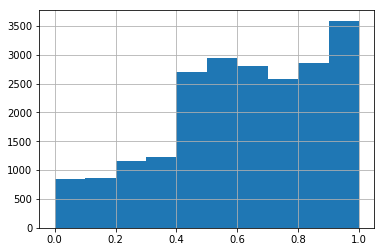

In [33]:
X_possible.yr_built.hist()

In [34]:
X_model = X_possible.drop(['floors_1.0', 'waterfront_missing', 'view_0.0', 'condition_1',
                           'grade_3', 'zipcode_98001', 'yr_renovated_cat_Never Renovated', 'season_Winter'], axis=1)
X_model = sm.add_constant(X_model)

In [35]:
model = sm.OLS(Y, X_model).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     1514.
Date:                Tue, 07 May 2019   Prob (F-statistic):               0.00
Time:                        12:24:38   Log-Likelihood:                 6369.2
No. Observations:               21597   AIC:                        -1.252e+04
Df Residuals:                   21489   BIC:                        -1.166e+04
Df Model:                         107                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    12.5865      0.185     68.162      0.000      12.225      12.948
date_num                                  0.0884      0.006     15.248      0.000       0.077       0.100
yr_built                                 -0.0243      0.009     -2.800      0.005      -0.041      -0.007
sqft_lot                                  0.0285      0.002     15.925      0.000       0.025       0.032
sqft_above                                0.1975      0.003     76.833      0.000       0.193       0.203
sqft_living15                             0.0602      0.002     27.072      0.000       0.056       0.065
sqft_lot15                                0.0022      0.002      1.188      0.235      -0.001       0.006
has_basement                              0.1274      0.003     41.783      0.000       0.121       0.133
floors_1.5                               -0.0221      0.005     -4.379      0.000      -0.032      -0.012
floors_2.0                               -0.0395      0.004     -9.627      0.000      -0.048      -0.031
floors_2.5                               -0.0442      0.015     -2.945      0.003      -0.074      -0.015
floors_3.0                               -0.1291      0.009    -13.807      0.000      -0.147      -0.111
floors_3.5                               -0.1049      0.069     -1.527      0.127      -0.240       0.030
waterfront_0.0                            0.0014      0.004      0.361      0.718      -0.006       0.009
waterfront_1.0                            0.4599      0.019     24.291      0.000       0.423       0.497
view_1.0                                  0.1152      0.010     11.202      0.000       0.095       0.135
view_2.0                                  0.1061      0.006     16.894      0.000       0.094       0.118
view_3.0                                  0.1794      0.009     20.964      0.000       0.163       0.196
view_4.0                                  0.3025      0.013     23.404      0.000       0.277       0.328
condition_2                               0.1243      0.037      3.404      0.001       0.053       0.196
condition_3                               0.2555      0.034      7.520      0.000       0.189       0.322
condition_4                               0.3052      0.034      8.978      0.000       0.239       0.372
condition_5                               0.3854      0.034     11.272      0.000       0.318       0.452
grade_4                                  -0.5532      0.184     -2.999      0.003      -0.915      -0.192
grade_5                                  -0.5931      0.182     -3.268      0.001      -0.949      -0.237
grade_6                                  -0.5262      0.181     -2.904      0.004      -0.881      -0.171
grade_7  

In [36]:
linreg = LinearRegression()
X_model = np.array(X_model)
linreg.fit(X_model, Y)


linreg_coefs = linreg.coef_
linreg_coefs[0] = linreg.intercept_

model.params - linreg_coefs


const                                    1.776357e-14
date_num                                 1.165734e-15
yr_built                                 1.975503e-14
sqft_lot                                -5.828671e-16
sqft_above                               0.000000e+00
sqft_living15                           -2.005340e-15
sqft_lot15                               5.898060e-17
has_basement                            -3.330669e-16
floors_1.5                               4.996004e-16
floors_2.0                              -2.900458e-15
floors_2.5                              -3.518019e-15
floors_3.0                               1.498801e-15
floors_3.5                              -3.039236e-15
waterfront_0.0                           2.498002e-15
waterfront_1.0                          -4.052314e-15
view_1.0                                 1.748601e-15
view_2.0                                -4.163336e-17
view_3.0                                 3.053113e-15
view_4.0                    

In [37]:
model_kfold = KFold(n_splits=10, shuffle=True)

MSEs = cross_val_score(linreg, X_model, Y, scoring='neg_mean_squared_error', cv=model_kfold)

mean_MSE = np.mean(MSEs)

print(mean_MSE)
print(MSEs)

-339208634156311.7
[-3.34737940e-02 -3.39208634e+15 -3.11266189e-02 -3.19937951e-02
 -3.14741270e-02 -3.29241573e-02 -3.54747736e-02 -3.37883614e-02
 -3.08920884e-02 -3.47457245e-02]


In [38]:
MSEs

array([-3.34737940e-02, -3.39208634e+15, -3.11266189e-02, -3.19937951e-02,
       -3.14741270e-02, -3.29241573e-02, -3.54747736e-02, -3.37883614e-02,
       -3.08920884e-02, -3.47457245e-02])

In [39]:
ridge = Ridge()

parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]}

ridge_regressor = GridSearchCV(ridge, parameters,scoring='neg_mean_squared_error', cv=5)

ridge_regressor.fit(X, Y)

/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.305671e-29
  overwrite_a=True).T
/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.422319e-29
  overwrite_a=True).T
/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.218038e-29
  overwrite_a=True).T
/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition numbe

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 1, 5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [40]:
lasso = Lasso()

parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]}

lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv = 5)

lasso_regressor.fit(X, Y)

/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objectiv

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 1, 5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [41]:
lasso_regressor.best_params_

{'alpha': 1e-15}

In [42]:
lasso_regressor.best_score_

-0.1351108121628674

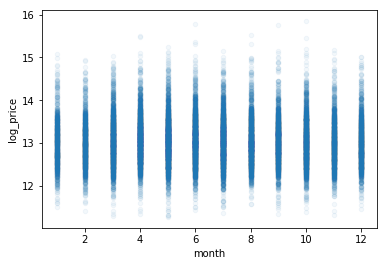

In [43]:
df_clean.plot(x='month', y='log_price', kind='scatter', alpha=0.05)

In [44]:
df_clean['month'] = df_clean['month'].astype(float)